<a href="https://colab.research.google.com/github/MINGYI123-bear/hello-world/blob/master/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
import tensorflow as tf
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
import random

In [3]:
device = torch.device("cpu")

In [4]:
random.seed(42)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Folds.csv")

In [6]:
df = df.rename(columns = {"filename":"path"})
df['filename'] = df['path'].apply(lambda x:x.split("/")[-1])
df["label"] = df['path'].apply(lambda x: x.split("/")[3])
df["sublabel"] = df['path'].apply(lambda x: x.split("/")[5])
df['file_loc'] = df['label'] + "_" + df['filename']

In [7]:
#Encoding the class to integer
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [8]:
train_df = df[df['grp'] == 'train']
test_df = df[df['grp'] == 'test']

In [9]:
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        # if transform is not None else transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      # Ensure you're extracting the image path as a string
        img_name = str(self.dataframe.iloc[idx]["path"])  # Convert to string to avoid TypeError

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        label = self.dataframe.iloc[idx]["class"]  # Assuming labels are in the second column and don't need conversion for your use case

        if self.transform:
            image = self.transform(image)

        return image, label



In [10]:
class Normalize(object):
    def __call__(self, img):
        mean = img.mean(dim=(1, 2), keepdim=True)
        std = img.std(dim=(1, 2), keepdim=True)
        return (img - mean) / std

train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224), #or (760, 460)?
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=40),
    Normalize()
])

# Define the transformation pipeline for test sets
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    Normalize()
])

In [11]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/BreaKHis_v1"
train_dataset = CustomImageDataset(dataframe=train_df, root_dir=root_dir, transform=train_transformations)
test_dataset = CustomImageDataset(dataframe=test_df, root_dir=root_dir, transform=test_transformations)

In [12]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)


In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images.shape

torch.Size([32, 3, 224, 224])

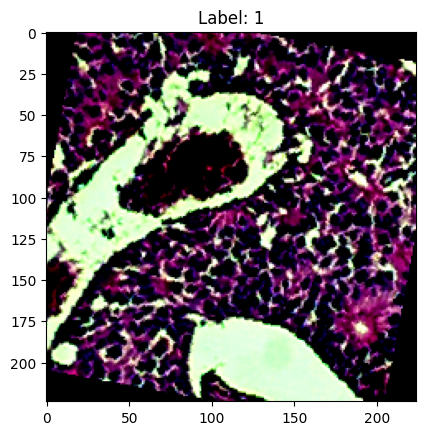

In [14]:
img = images[0].numpy()
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.show()

In [15]:
import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Assuming images are 256*256 and RGB
        self.encoder = nn.Sequential(
            nn.Linear(224*224*3, 128),
            nn.ReLU(),
            # Add more layers as needed...
        )
        self.decoder = nn.Sequential(
            # Decoder layers...
            nn.Linear(128, 224*224*3),  # Adjust the output size to match the input
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
num_epochs = 3  # Number of epochs for training

for epoch in range(num_epochs):
    for images, _ in train_loader:  # We ignore the labels here
        # Flatten images
        images = images.to(device)
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Loss: 0.9288
Epoch [2/3], Loss: 0.9012
Epoch [3/3], Loss: 0.9006


In [18]:
def encode_images(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in data_loader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            encoded_imgs = model.encoder(img)
            features.append(encoded_imgs.cpu().numpy())
    return np.concatenate(features, axis=0)

In [19]:
from sklearn.cluster import KMeans

encoded_images = encode_images(model, train_loader)
print(encoded_images.shape)
print(type(encoded_images))

(25880, 128)
<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2, SSE is 612908672.0, Silhouette score is 0.5100593566894531


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3, SSE is 513000000.0, Silhouette score is 0.5147446393966675


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, SSE is 465389600.0, Silhouette score is 0.5128977298736572


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, SSE is 426951232.0, Silhouette score is 0.3884957432746887


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, SSE is 394525984.0, Silhouette score is 0.3860851228237152


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, SSE is 372719392.0, Silhouette score is 0.3896431624889374


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, SSE is 356303616.0, Silhouette score is 0.3014300465583801


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, SSE is 340199424.0, Silhouette score is 0.32266250252723694


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, SSE is 325103392.0, Silhouette score is 0.32675471901893616


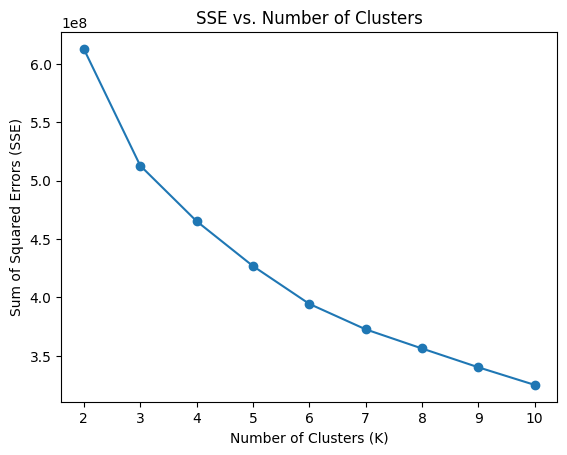

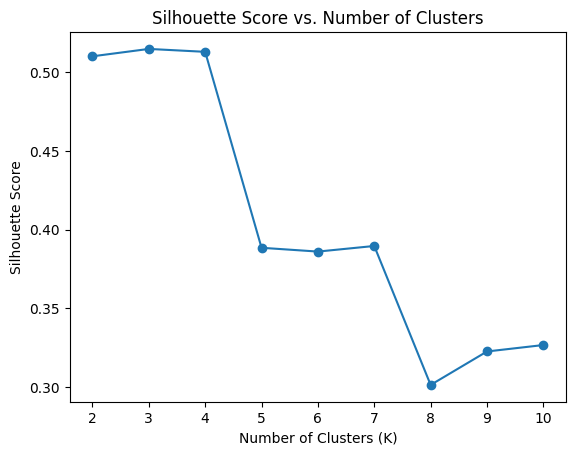

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_cluster_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
sse_list = []
silhouette_scores = []

for n_clusters in n_cluster_list:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(encoded_images)


    sse = kmeans.inertia_
    sse_list.append(sse)


    silhouette_avg = silhouette_score(encoded_images, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"For n_clusters = {n_clusters}, SSE is {sse}, Silhouette score is {silhouette_avg}")

# show how the coefficient changes with the K value
plt.figure()
plt.plot(n_cluster_list, sse_list, 'o-')
plt.title('SSE vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

plt.figure()
plt.plot(n_cluster_list, silhouette_scores, 'o-')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()


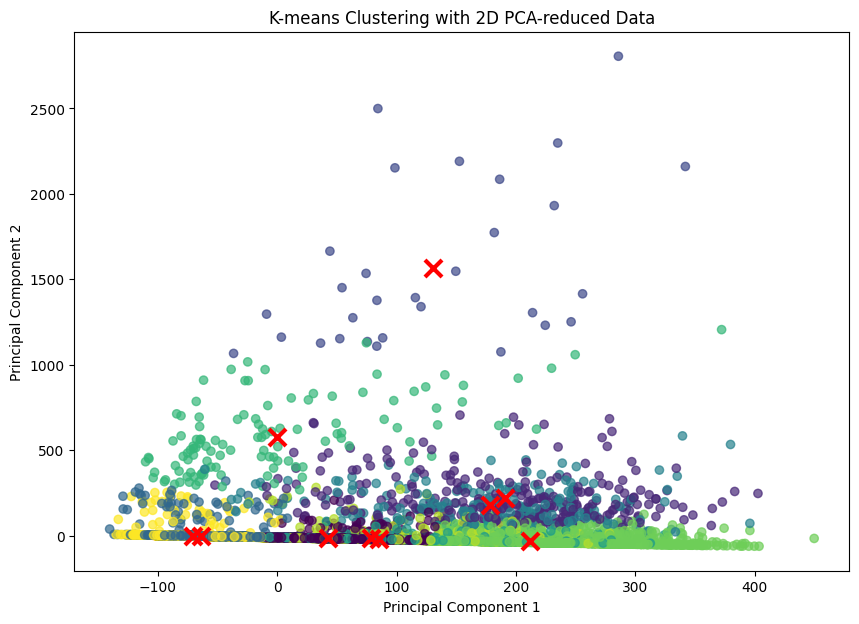

In [21]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_images)
cluster_labels = kmeans.predict(encoded_images)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o', alpha=0.7)

# Optionally, mark the centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, linewidths=3, color='r')

plt.title('K-means Clustering with 2D PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
